# <center> 
# <center> 3h. SARMA Application
## <center> ECO374

If using Colab, mount Google Drive and set path to files

In [1]:
import os
IN_COLAB = 'COLAB_GPU' in os.environ 
if IN_COLAB:
  from google.colab import drive; mount_path = '/content/drive'
  not os.path.ismount(mount_path) and drive.mount(mount_path)
  os.chdir('/content/drive/MyDrive/Colab Notebooks/Python_code') # Set Python file directory

Set up R for Python

In [2]:
import R_for_Python_setup as RPY
RPY.setup_R()
ro, pandas2ri, StrVector = RPY.initialize_rpy2()
%load_ext rpy2.ipython

R installed
Operating system: Windows
Development tool: Anaconda


Load R packages

In [3]:
R_packages = ['forecast']
RPY.load_R_packages(R_packages)

R packages loaded: forecast


Load Python packages

In [4]:
pth_packages = ['pandas_datareader']
import subprocess, sys
for pkg in pth_packages: subprocess.run([sys.executable, '-m', 'pip', 'install', pkg, '--quiet'], check=True)
import numpy as np, pandas as pd, pandas_datareader.data as web
import datetime as dt, matplotlib.pyplot as plt, matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## 1. Data
U.S. Labor Force Participation Rate, monthly ([Source](https://fred.stlouisfed.org/series/CIVPART))

In [5]:
TLRESCON = web.DataReader('TLRESCON', 'fred', start=dt.datetime(2002,1,1), end=dt.datetime(2024,1,1))
TLRESCON = TLRESCON.asfreq('MS') 
TLRESCON = pd.DataFrame(TLRESCON)
TLR_c = 100*TLRESCON.pct_change() 
TLR_c = TLR_c.dropna()

Plot the data

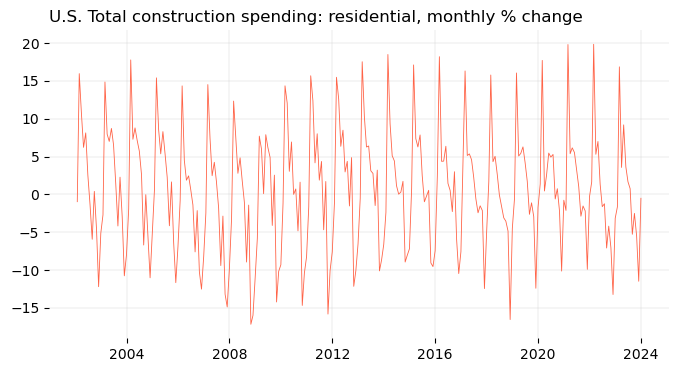

In [6]:
plt.figure(figsize=(8, 4))
plt.plot(TLR_c, '-', color='tomato', linewidth=0.6)
plt.title('U.S. Total construction spending: residential, monthly % change', loc='left')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.grid(which='major', color='lightgrey', linewidth=0.3)
plt.box(False)
plt.show()

# 2. ACF and PACF

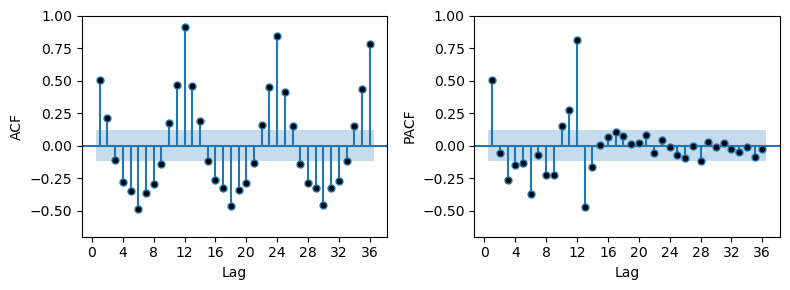

In [7]:
lag_max = 36

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
axs = axs.flatten()

plot_acf(TLR_c, lags=lag_max, alpha=0.05, zero=False, mfc='black', 
         bartlett_confint=False, title=None, ax=axs[0])
axs[0].set_ylabel('ACF')
axs[0].set_xticks(np.arange(0, lag_max+1, step=4))

plot_pacf(TLR_c, lags=lag_max, alpha=0.05, zero=False, mfc='black', 
          title=None, ax=axs[1])
axs[1].set_ylabel('PACF')
axs[1].set_xticks(np.arange(0, lag_max+1, step=4))

for ax in axs:
    ax.set_ylim(-0.7,1)
    ax.set_xlabel('Lag')

fig.tight_layout() 

plt.show() 
  

# 3. ARMA automatic model selection
For seasonal ARMA automatic model selection we need to indicate the frequency of the data in any one season (here 12 months in 1 year) in the `ts()` function wrapper, and set the `seasonal=` indicator to `TRUE`.

In [8]:
ro.globalenv['TLR_c'] = TLR_c # copy data from Python to R

In [9]:
%%R
SARMA <- forecast::auto.arima(stats::ts(TLR_c,frequency=12), seasonal=TRUE, stepwise=FALSE)
SARMA

Series: stats::ts(TLR_c, frequency = 12) 
ARIMA(2,0,1)(2,1,0)[12] 

Coefficients:
         ar1     ar2     ma1     sar1     sar2
  0.0522  0.4047  0.3396  -0.2024  -0.0533
  0.2864  0.1297  0.3180   0.0660   0.0666

3.893:  log likelihood = -526.77
AIC=1065.54   AICc=1065.88   BIC=1086.71


Forecasting with the fitted model object `SARMA` will proceed along the same lines as with the ARMA model covered earlier. 